<a href="https://colab.research.google.com/github/tahama2000/Botnet_Detection/blob/main/Botnet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Botnet Detection

In [3]:
import os
import time
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from shutil import copyfile
from tensorflow.keras import layers, losses, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
#import numpy as np


# Load Data

In [5]:
#General node

# General parameters for Auto Loading
path_root='/content/drive/MyDrive/Botnet/NBaIoT/' # Points to data folder
number_of_nodes = 2 # Number of devices = Number of nodes (max 7)


def load_node_k_data(node_number_in):
    node_number = str(node_number_in)
    # Load data for Node # n
    benign =pd.read_csv(path_root+ node_number+'.benign.csv')
    mirai_ack =pd.read_csv(path_root+ node_number+'.mirai.ack.csv')
    mirai_scan = pd.read_csv(path_root + node_number+'.mirai.scan.csv')
    mirai_syn = pd.read_csv(path_root + node_number+'.mirai.syn.csv')
    mirai_udp = pd.read_csv(path_root + node_number+'.mirai.udp.csv')
    mirai_udp_plain = pd.read_csv(path_root + node_number+'.mirai.udpplain.csv')
    gafgyt_combo = pd.read_csv(path_root + node_number+'.gafgyt.combo.csv')
    gafgyt_junk = pd.read_csv(path_root + node_number+'.gafgyt.junk.csv')
    gafgyt_scan = pd.read_csv(path_root + node_number+'.gafgyt.scan.csv')
    gafgyt_tcp = pd.read_csv(path_root + node_number+'.gafgyt.tcp.csv')
    gafgyt_udp = pd.read_csv(path_root + node_number+'.gafgyt.udp.csv')

    # Create type column for Node # n
    benign['type']= 0 #'benign'
    mirai_ack['type']=1 #'mirai_ack'
    mirai_scan['type']=2 #'mirai_scan'
    mirai_syn['type'] = 3 #'mirai_syn'
    mirai_udp['type'] = 4 #'mirai_udp'
    mirai_udp_plain['type'] = 5 #'mirai_udp_plain'

    gafgyt_combo['type'] = 6 #'gafgyt_combo'
    gafgyt_junk['type'] = 7 #'gafgyt_junk'
    gafgyt_scan['type'] = 8 #'gafgyt_scan'
    gafgyt_tcp['type'] = 9 #'gafgyt_tcp'
    gafgyt_udp['type'] = 10 #'gafgyt_udp'

    #construct the main dataset for node # n
    node_n_data = pd.concat([benign,
                  mirai_ack, mirai_scan, mirai_syn, mirai_udp, mirai_udp_plain,
                 gafgyt_combo, gafgyt_junk, gafgyt_scan, gafgyt_tcp, gafgyt_udp],
                 axis=0, sort=False, ignore_index=True)

    return node_n_data

def load_all_nodes_data(num_nodes):
    nodes_data = {}
    for node in range(1, num_nodes + 1):
        nodes_data[node] = load_node_k_data(node)
    return nodes_data

def get_node_data(nodes_data, node_number):
    return nodes_data.get(node_number, f"No data found for node {node_number}.")


nodes_data = load_all_nodes_data(number_of_nodes)
node1_data = get_node_data(nodes_data,1)
node1_data.groupby('type')['type'].count()


def separate_node_features(node_data, scale=False):
    # Separate features and the target
    features = node_data.drop('type', axis=1)
    labels = node_data['type']

        # Scaling if scale is True
    if scale:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        return features_scaled, labels
    else:
        return features, labels


#node1_features , node1_labels = separate_node_features(get_node_data(nodes_data,1))
#node2_features , node2_labels = separate_node_features(get_node_data(nodes_data,2))

In [6]:
print(node1_data.groupby('type')['type'].count())
print(node1_data.count())

type
0      49548
1     102195
2     107685
3     122573
4     237665
5      81982
6      59718
7      29068
8      29849
9      92141
10    105874
Name: type, dtype: int64
MI_dir_L5_weight         1018298
MI_dir_L5_mean           1018298
MI_dir_L5_variance       1018298
MI_dir_L3_weight         1018298
MI_dir_L3_mean           1018298
                          ...   
HpHp_L0.01_magnitude     1018298
HpHp_L0.01_radius        1018298
HpHp_L0.01_covariance    1018298
HpHp_L0.01_pcc           1018298
type                     1018298
Length: 116, dtype: int64


Describe Dataset for Nodes_data

In [26]:
import pandas as pd

def summarize_nodes_data(nodes_data):
    summary = {}

    for node, data in nodes_data.items():
        # Basic summary for each node
        node_summary = {
            'Node Number': node,
            'Number of Records': data.shape[0],
            'Label/Type': data['type'].iloc[0] if 'type' in data.columns else 'N/A'
        }

        # Append this node's summary to the main summary dictionary
        summary[node] = node_summary

    return summary

# Example usage
# nodes_data = {
#     'Node1': pd.DataFrame({'type': ['A']*100, 'feature1': range(100)}),
#     'Node2': pd.DataFrame({'type': ['B']*200, 'feature1': range(200)}),
#     ...
# }
summary_info = summarize_nodes_data(nodes_data)
for node, info in summary_info.items():
    print(f"Summary for {node}:")
    for key, value in info.items():
        print(f"{key}: {value}")
    print("\n" + "-"*50 + "\n")


Summary for 1:
Node Number: 1
Number of Records: 1018298
Label/Type: 0

--------------------------------------------------

Summary for 2:
Node Number: 2
Number of Records: 835876
Label/Type: 0

--------------------------------------------------

Summary for 3:
Node Number: 3
Number of Records: 863056
Label/Type: 0

--------------------------------------------------

Summary for 4:
Node Number: 4
Number of Records: 1098677
Label/Type: 0

--------------------------------------------------

Summary for 5:
Node Number: 5
Number of Records: 828260
Label/Type: 0

--------------------------------------------------

Summary for 6:
Node Number: 6
Number of Records: 836891
Label/Type: 0

--------------------------------------------------

Summary for 7:
Node Number: 7
Number of Records: 850826
Label/Type: 0

--------------------------------------------------



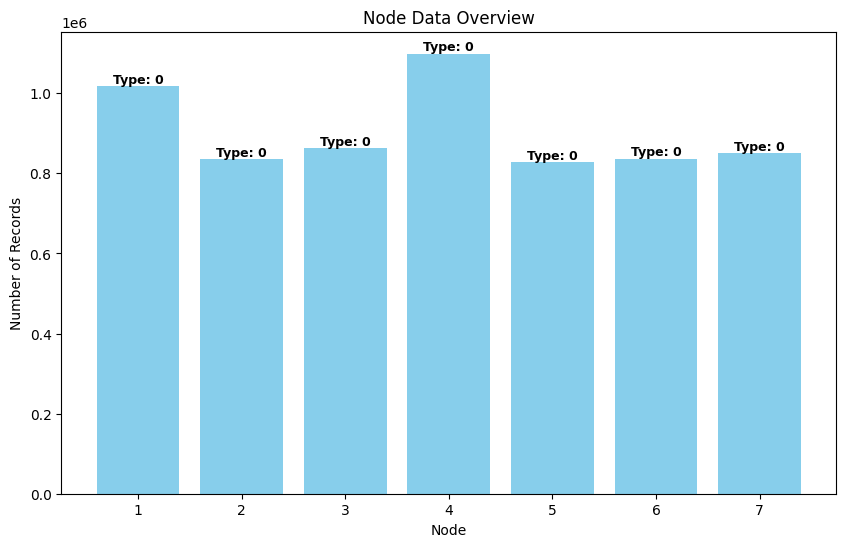

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

def summarize_nodes_data(nodes_data):
    summary = []

    for node, data in nodes_data.items():
        node_summary = {
            'Node': node,
            'Number of Records': data.shape[0],
            'Label/Type': data['type'].iloc[0] if 'type' in data.columns else 'N/A'
        }
        summary.append(node_summary)

    return pd.DataFrame(summary)

# Assuming nodes_data is a dictionary with pandas DataFrames
# Example of how the data might be structured:
# nodes_data = {
#     'Node1': pd.DataFrame({'type': ['Type A']*100, 'feature1': range(100)}),
#     'Node2': pd.DataFrame({'type': ['Type B']*200, 'feature1': range(200)}),
# }

# Summarize data
summary_df = summarize_nodes_data(nodes_data)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['Node'], summary_df['Number of Records'], color='skyblue')
plt.xlabel('Node')
plt.ylabel('Number of Records')
plt.title('Node Data Overview')

# Annotate each bar with the type/label from the data
for bar, label in zip(bars, summary_df['Label/Type']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'Type: {label}', ha='center', va='bottom', fontdict={'fontweight':'bold', 'size':9})

plt.show()



# Part # 1: Machine Learning Model Selection

In [10]:

def split_node_data(features, labels, test_size=0.2, random_state=42):
    """
    Splits the node data into training and validation sets.

    Parameters:
    features (pandas.DataFrame or numpy.ndarray): The features for the nodes.
    labels (pandas.Series or numpy.ndarray): The labels for the nodes.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): Controls the shuffling applied to the data before applying the split.

    Returns:
    tuple: Training and validation sets for both features and labels.
    """
    features_train, features_val, labels_train, labels_val = train_test_split(
        features, labels, test_size=test_size, random_state=random_state)
    return features_train, features_val, labels_train, labels_val

def calculate_accuracy(true_labels, predictions):
    """
    Calculates and returns the accuracy of predictions against true labels.
    """
    return accuracy_score(true_labels, predictions)


def apply_feature_scaling(features, scale):
    """
    Applies feature scaling to the features if scale is True.

    Parameters:
    features (pandas.DataFrame or numpy.ndarray): The features to be scaled.
    scale (bool): Whether to apply scaling.

    Returns:
    The scaled features if scale is True, otherwise the original features.
    """
    if scale:
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
        return features_scaled
    else:
        return features

def train_and_evaluate_with_cv(node_features, node_labels, classifier_type, folds=2):
    """
    Trains a specified classifier on node features and labels using cross-validation,
    evaluates its performance, and returns the average accuracy and standard deviation across folds,
    along with average training time.
    """
    # Determine if feature scaling is needed
    scale = classifier_type in ['knn', 'svm']

    # Apply feature scaling conditionally
    if scale:
        node_features = apply_feature_scaling(node_features, scale=True)

    # Initialize the classifier based on the input parameter
    if classifier_type == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=42)
    elif classifier_type == 'knn':
        clf = KNeighborsClassifier()
    elif classifier_type == 'svm':
        clf = LinearSVC(random_state=42, max_iter=10000) #SVC(random_state=42)
    elif classifier_type == 'logistic_regression':
        clf = LogisticRegression(max_iter=1000, random_state=42)
    else:
        raise ValueError("Unsupported classifier type provided.")

    # Use cross-validation to evaluate the classifier
    start_time = time.time()
    cv_scores = cross_val_score(clf, node_features, node_labels, cv=folds, scoring='accuracy')
    end_time = time.time()
    training_time = (end_time - start_time) / folds  # Average training time per fold

    # Calculate average accuracy and standard deviation across folds
    avg_accuracy = np.mean(cv_scores)
    std_dev = np.std(cv_scores)

    return clf, avg_accuracy, std_dev, training_time

# Example usage:
# Assuming node_features and node_labels are your dataset
# trained_model, avg_accuracy, accuracy_std, avg_training_time = train_and_evaluate_with_cv(node_features, node_labels, 'knn')
# print(f"Average model accuracy: {avg_accuracy:.4f} with std dev: {accuracy_std:.4f}")
# print(f"Average training time per fold: {avg_training_time:.4f} seconds")





Version # 2: Cross Validation as parameter

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import time
from sklearn.svm import LinearSVC
#from cuml import SVC as GPUSVC  # For SVM training on GPU


def train_and_evaluate_with_cv_v2(node_features, node_labels, classifier_type, use_cv=False, n_folds=5):
    """
    Trains a specified classifier on node features and labels, optionally using cross-validation,
    and returns the trained model, average accuracy, standard deviation of accuracy (if cross-validation is used),
    and average training time.

    Parameters:
    node_features (pandas.DataFrame or numpy.ndarray): The feature set.
    node_labels (pandas.Series or numpy.ndarray): The labels.
    classifier_type (str): The classifier ('decision_tree', 'knn', 'svm', 'logistic_regression').
    use_cv (bool): Whether to use cross-validation.
    n_folds (int): The number of folds for cross-validation (ignored if use_cv is False).

    Returns:
    tuple: The trained model, average accuracy, standard deviation of accuracy (None if not using CV), and training time.
    """
    # Initialize the classifier
    if classifier_type == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=42)
    elif classifier_type == 'knn':
        clf = KNeighborsClassifier(n_neighbors=11, n_jobs=-1) # as we have 11 classes ==> 10 maleware and 1 normal
    elif classifier_type == 'svm':
        clf = LinearSVC(max_iter=1000000 ) #SVC(random_state=42) - max_iter=10000 SVC(kernel='rbf', gamma='auto')
    elif classifier_type == 'logistic_regression':
        clf = LogisticRegression(max_iter=1000000, random_state=42)
    else:
        raise ValueError("Unsupported classifier type provided.")

    # Determine if feature scaling is needed
    scale = classifier_type in ['knn', 'svm']

    start_time = time.time()

    if use_cv:
        # Apply feature scaling for SVM and KNN if using CV
        if scale:
            scaler = StandardScaler()
            node_features = scaler.fit_transform(node_features)

        # Use cross-validation to evaluate the classifier
        cv_scores = cross_val_score(clf, node_features, node_labels, cv=n_folds, scoring='accuracy')
        avg_accuracy = np.mean(cv_scores)
        std_dev = np.std(cv_scores)
    else:
        # Split the data into training and validation sets if not using CV
        features_train, features_val, labels_train, labels_val = train_test_split(
            node_features, node_labels, test_size=0.2, random_state=42)

        # Apply feature scaling for SVM and KNN if not using CV
        if scale:
            scaler = StandardScaler()
            features_train = scaler.fit_transform(features_train)
            features_val = scaler.transform(features_val)

        # Train the classifier
        clf.fit(features_train, labels_train)

        # Predict on the validation set
        predictions = clf.predict(features_val)

        # Calculate accuracy
        avg_accuracy = accuracy_score(labels_val, predictions)
        std_dev = None  # Standard deviation is not applicable

    end_time = time.time()
    training_time = (end_time - start_time) / (n_folds if use_cv else 1)

    return clf, avg_accuracy, std_dev, training_time




Version # 3: With PCA for distance-based algorithm

In [7]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import time

def train_and_evaluate_with_pca_cv(node_features, node_labels, classifier_type, use_cv=False, n_folds=5):
    """
    Trains a specified classifier using PCA on node features and labels, optionally using cross-validation,
    and returns the trained model, average accuracy, standard deviation of accuracy (if cross-validation is used),
    and average training time.

    Parameters:
    node_features (pandas.DataFrame or numpy.ndarray): The feature set.
    node_labels (pandas.Series or numpy.ndarray): The labels.
    classifier_type (str): The classifier ('decision_tree', 'knn', 'svm', 'logistic_regression').
    use_cv (bool): Whether to use cross-validation.
    n_folds (int): The number of folds for cross-validation (ignored if use_cv is False).

    Returns:
    tuple: The trained model, average accuracy, standard deviation of accuracy (None if not using CV), and training time.
    """
    # Initialize the classifier
    if classifier_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42)
    elif classifier_type == 'knn':
        pca = PCA(n_components=0.95)  # retain 95% of variance
        model = Pipeline([
            ('pca', pca),
            ('knn', KNeighborsClassifier(n_neighbors=11, n_jobs=-1))
        ])
    elif classifier_type == 'svm':
        pca = PCA(n_components=0.95)  # retain 95% of variance
        model = Pipeline([
            ('pca', pca),
            ('svm', LinearSVC(random_state=42))
        ])
    elif classifier_type == 'logistic_regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
    else:
        raise ValueError("Unsupported classifier type provided.")

    # Train the model with or without cross-validation
    if use_cv:
        # Apply feature scaling universally before using PCA
        scaler = StandardScaler()
        node_features = scaler.fit_transform(node_features)

        # Use cross-validation to evaluate the classifier
        cv_scores = cross_val_score(model, node_features, node_labels, cv=n_folds, scoring='accuracy')
        avg_accuracy = np.mean(cv_scores)
        std_dev = np.std(cv_scores)
        training_time = None  # To be calculated if necessary
    else:
        # Split data into training and validation sets
        features_train, features_val, labels_train, labels_val = train_test_split(
            node_features, node_labels, test_size=0.2, random_state=42)

        # Feature scaling for all models
        scaler = StandardScaler()
        features_train = scaler.fit_transform(features_train)
        features_val = scaler.transform(features_val)

        start_time = time.time()
        model.fit(features_train, labels_train)
        end_time = time.time()
        training_time = end_time - start_time

        # Predict on the validation set
        predictions = model.predict(features_val)

        # Calculate accuracy
        avg_accuracy = accuracy_score(labels_val, predictions)
        std_dev = None  # Standard deviation not applicable here

    return model, avg_accuracy, std_dev, training_time

Test # 1

In [10]:
node_data_test = get_node_data(nodes_data, 1)
node_features, node_labels = separate_node_features(node_data_test)
#['decision_tree', 'knn', 'svm', 'logistic_regression']
trained_model, avg_accuracy, accuracy_std, avg_training_time = train_and_evaluate_with_cv_v2(node_features, node_labels, 'knn')
print(avg_accuracy,accuracy_std, avg_training_time)
#print(f"Average training time per fold: {avg_training_time:.4f} seconds")

0.9994451536875184 None 169.99168872833252


Test # 2

In [11]:
node_data_test = get_node_data(nodes_data, 1)
node_features, node_labels = separate_node_features(node_data_test)
#['decision_tree', 'knn', 'svm', 'logistic_regression']
trained_model, avg_accuracy, accuracy_std, avg_training_time = train_and_evaluate_with_pca_cv(node_features, node_labels, 'knn')
print(f"Average model accuracy: {avg_accuracy:.4f}")
print(f"Average training time per fold: {avg_training_time:.4f} seconds")

Average model accuracy: 0.9979
Average training time per fold: 6.3574 seconds


Test Training function

In [ ]:
node_data_test = get_node_data(nodes_data, 1)
node_features, node_labels = separate_node_features(node_data_test)
#['decision_tree', 'knn', 'svm', 'logistic_regression']
trained_model, avg_accuracy, accuracy_std, avg_training_time = train_and_evaluate_with_cv_v2(node_features, node_labels, 'svm')
print(f"Average model accuracy: {avg_accuracy:.4f} with std dev: {accuracy_std:.4f}")
print(f"Average training time per fold: {avg_training_time:.4f} seconds")

## Calculate average figuers

In [8]:
#import pandas as pd
#from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression
#import numpy as np
#import time

# Assuming nodes_data is a dictionary with DataFrames for each node
# Assuming get_node_data retrieves data for a specific node number
"""
def separate_node_features(node_data, label_column='type'):

    Separates features and the target from a node's DataFrame.

    Parameters:
    node_data (pandas.DataFrame): DataFrame containing the node's data.
    label_column (str): Name of the column to use as the label.

    Returns:
    tuple: Features (DataFrame), Labels (Series).

    features = node_data.drop(label_column, axis=1)
    labels = node_data[label_column]
    return features, labels
"""


# The train_and_evaluate_with_cv function as defined previously goes here

results = []

# Classifier types
classifier_types = ['decision_tree', 'knn', 'logistic_regression'] #['decision_tree', 'knn', 'svm', 'logistic_regression']

# Loop over each node in nodes_data
for node in nodes_data.keys():
    node_data = get_node_data(nodes_data, node)
    node_features, node_labels = separate_node_features(node_data)

    # Loop through each classifier type
    for classifier_type in classifier_types:
        # Train the model and get the evaluation metrics
        _, avg_accuracy, _, avg_training_time = train_and_evaluate_with_pca_cv(node_features, node_labels, classifier_type)

        # Append the results
        results.append({
            'Node': node,
            'Model': classifier_type,
            'Accuracy': avg_accuracy,
            'Training Time': avg_training_time
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate and display the average accuracy and training time per node per classifier type
average_metrics = results_df.groupby(['Node', 'Model']).agg({'Accuracy': 'mean', 'Training Time': 'mean'}).reset_index()

print(average_metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

    Node                Model  Accuracy  Training Time
0      1        decision_tree  0.908927      27.371488
1      1                  knn  0.997918       5.415099
2      1  logistic_regression  0.895100     371.145478
3      2        decision_tree  0.887436      24.124977
4      2                  knn  0.994407       6.694162
5      2  logistic_regression  0.870149     319.115732
6      3        decision_tree  0.897197      22.666216
7      3                  knn  0.994491       4.583403
8      3  logistic_regression  0.882505     331.528800
9      4        decision_tree  0.915676      40.593945
10     4                  knn  0.998043       5.738678
11     4  logistic_regression  0.900603     404.696921
12     5        decision_tree  0.874273      28.493812
13     5                  knn  0.995152       6.626049
14     5  logistic_regression  0.851007     314.814957
15     6        decision_tree  0.894204      26.388154
16     6                  knn  0.996075       6.699237
17     6  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Average figuresiguers without PCA

In [24]:
#import pandas as pd
#from sklearn.model_selection import cross_val_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression
#import numpy as np
#import time

# Assuming nodes_data is a dictionary with DataFrames for each node
# Assuming get_node_data retrieves data for a specific node number
"""
def separate_node_features(node_data, label_column='type'):

    Separates features and the target from a node's DataFrame.

    Parameters:
    node_data (pandas.DataFrame): DataFrame containing the node's data.
    label_column (str): Name of the column to use as the label.

    Returns:
    tuple: Features (DataFrame), Labels (Series).

    features = node_data.drop(label_column, axis=1)
    labels = node_data[label_column]
    return features, labels
"""


# The train_and_evaluate_with_cv function as defined previously goes here

results = []

# Classifier types
classifier_types = ['decision_tree', 'knn', 'logistic_regression'] #['decision_tree', 'knn', 'svm', 'logistic_regression']

# Loop over each node in nodes_data
for node in nodes_data.keys():
    node_data = get_node_data(nodes_data, node)
    node_features, node_labels = separate_node_features(node_data)

    # Loop through each classifier type
    for classifier_type in classifier_types:
        # Train the model and get the evaluation metrics
        _, avg_accuracy, _, avg_training_time = train_and_evaluate_with_cv_v2(node_features, node_labels, classifier_type)

        # Append the results
        results.append({
            'Node': node,
            'Model': classifier_type,
            'Accuracy': avg_accuracy,
            'Training Time': avg_training_time
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Calculate and display the average accuracy and training time per node per classifier type
average_metrics_2 = results_df.groupby(['Node', 'Model']).agg({'Accuracy': 'mean', 'Training Time': 'mean'}).reset_index()

print(average_metrics_2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr

    Node                Model  Accuracy  Training Time
0      1        decision_tree  0.999828      34.169548
1      1                  knn  0.999445     168.499819
2      1  logistic_regression  0.048861       9.252990
3      2        decision_tree  0.997775      29.786909
4      2                  knn  0.998995     115.052823
5      2  logistic_regression  0.015331       7.909873
6      3        decision_tree  0.999948      29.002508
7      3                  knn  0.990256     122.912988
8      3  logistic_regression  0.053473       8.075800
9      4        decision_tree  0.997001      53.055828
10     4                  knn  0.999436     194.990562
11     4  logistic_regression  0.159214       9.904384
12     5        decision_tree  0.992496      33.843808
13     5                  knn  0.999010     113.752080
14     5  logistic_regression  0.074832       7.550988
15     6        decision_tree  0.999869      33.180389
16     6                  knn  0.999068     115.163923
17     6  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Export Data as CSV file

In [9]:
average_metrics.to_csv('average_metrics_wto_score.csv', index=False)

### Calculate the score

In [10]:
def model_score(accuracy, training_time, max_training_time, accuracy_weight=0.5, training_time_weight=0.5):
    """
    Calculates a weighted score for a model based on its accuracy and training time.

    Parameters:
    accuracy (float): The accuracy of the model (assumed to be between 0 and 1).
    training_time (float): The training time of the model in seconds.
    max_training_time (float): The maximum observed training time across all models, used for normalization.
    accuracy_weight (float): The weight for the accuracy score component.
    training_time_weight (float): The weight for the training time score component.

    Returns:
    float: The calculated weighted score of the model.
    """
    # Normalize accuracy and training time to a scale of 0 to 1
    normalized_accuracy = accuracy  # Assuming accuracy is already between 0 and 1
    normalized_training_time = 1 - (training_time / max_training_time)  # Invert and normalize training time

    # Calculate weighted score
    score = (accuracy_weight * normalized_accuracy) + (training_time_weight * normalized_training_time)

    return score

# Example usage
accuracy_example = 0.9  # Example accuracy
training_time_example = 60  # Example training time in seconds
max_training_time_observed = 120  # Maximum training time observed among all models

# Calculate the model score with equal weights for accuracy and training time
model_score_example = model_score(accuracy_example, training_time_example, max_training_time_observed)
print(f"Model Score: {model_score_example:.4f}")

# Find the maximum training time across all nodes and models for normalization
max_training_time_observed = average_metrics['Training Time'].max()

# Calculate the score for each row and add it as a new column
average_metrics['Score'] = average_metrics.apply(
    lambda row: model_score(
        accuracy=row['Accuracy'],
        training_time=row['Training Time'],
        max_training_time=max_training_time_observed,
        accuracy_weight=0.5,
        training_time_weight=0.5
    ), axis=1)

# Now 'average_metrics' contains an additional column 'Score' for each node and model combination
print(average_metrics)

average_metrics.to_csv('average_metrics_wt_score.csv', index=False)

Model Score: 0.7000
    Node                Model  Accuracy  Training Time     Score
0      1        decision_tree  0.908927      27.371488  0.920646
1      1                  knn  0.997918       5.415099  0.992269
2      1  logistic_regression  0.895100     371.145478  0.489002
3      2        decision_tree  0.887436      24.124977  0.913912
4      2                  knn  0.994407       6.694162  0.988933
5      2  logistic_regression  0.870149     319.115732  0.540809
6      3        decision_tree  0.897197      22.666216  0.920595
7      3                  knn  0.994491       4.583403  0.991583
8      3  logistic_regression  0.882505     331.528800  0.531651
9      4        decision_tree  0.915676      40.593945  0.907685
10     4                  knn  0.998043       5.738678  0.991931
11     4  logistic_regression  0.900603     404.696921  0.450302
12     5        decision_tree  0.874273      28.493812  0.901932
13     5                  knn  0.995152       6.626049  0.989390
14   

Visualization

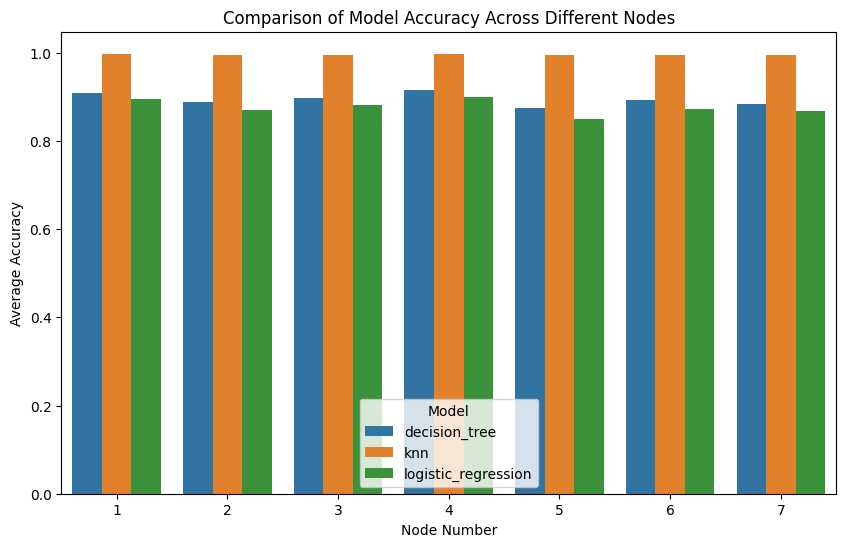

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your average_metrics DataFrame
# average_metrics = pd.DataFrame(...)

# Creating a grouped bar graph for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Node', y='Accuracy', hue='Model', data=average_metrics)
plt.title('Comparison of Model Accuracy Across Different Nodes')
plt.xlabel('Node Number')
plt.ylabel('Average Accuracy')
plt.legend(title='Model')
plt.show()


Graph # 2

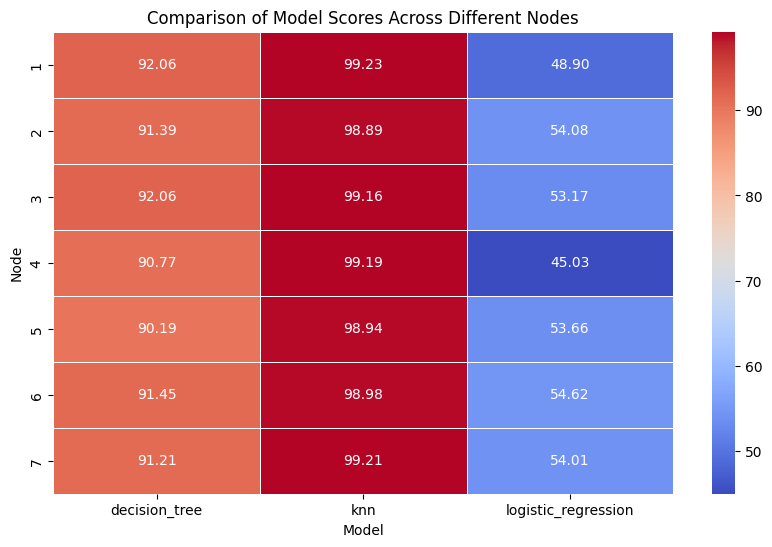

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data creation (assuming your DataFrame looks similar to this)
# average_metrics = pd.DataFrame({
#     'Node': ['Node1', 'Node1', 'Node2', 'Node2', 'Node3', 'Node3'],
#     'Model': ['Decision Tree', 'SVM', 'Decision Tree', 'SVM', 'Decision Tree', 'SVM'],
#     'Score': [0.85, 0.90, 0.88, 0.86, 0.87, 0.89]
# })

# Pivot the DataFrame to format suitable for a heatmap
average_metrics['Score'] = average_metrics['Score'] * 100
score_pivot = average_metrics.pivot(index="Node", columns="Model", values="Score")

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(score_pivot, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Comparison of Model Scores Across Different Nodes')
plt.xlabel('Model')
plt.ylabel('Node')
plt.show()

average_metrics['Score'] = average_metrics['Score'] / 100

### Proof that we need federated learning

Using KNN

In [21]:
node_data_1 = get_node_data(nodes_data, 1)
node_data_2 = get_node_data(nodes_data, 2)
node_features_1, node_labels_1 = separate_node_features(node_data_1)
node_features_2, node_labels_2 = separate_node_features(node_data_2)
Model_1, avg_accuracy_1, _, avg_training_time_1 = train_and_evaluate_with_cv_v2(node_features_1, node_labels_1, 'knn')
print(f"Model # 1 Average model accuracy: {avg_accuracy_1:.4f}")

Model_2, avg_accuracy_2, _, avg_training_time_2 = train_and_evaluate_with_cv_v2(node_features_2, node_labels_2, 'knn')
print(f"Model # 2 Average model accuracy: {avg_accuracy_2:.4f}")

features_train_1, features_val_1, labels_train_1, labels_val_1 = split_node_data(node_features_1, node_labels_1)
features_train_2, features_val_2, labels_train_2, labels_val_2 = split_node_data(node_features_2, node_labels_2)

# Predict on node #2 validation data
predictions = Model_1.predict(features_val_2)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_2, predictions)

print('Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2')
print(accuracy)


# Predict on node #1 validation data
predictions = Model_2.predict(features_val_1)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_1, predictions)

print('Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1')
print(accuracy)


Model # 1 Average model accuracy: 0.9994
Model # 2 Average model accuracy: 0.9990


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2
0.038001866296597596


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1
0.131174506530492


Using Decision Tree

In [22]:
node_data_1 = get_node_data(nodes_data, 1)
node_data_2 = get_node_data(nodes_data, 2)
node_features_1, node_labels_1 = separate_node_features(node_data_1)
node_features_2, node_labels_2 = separate_node_features(node_data_2)
Model_1, avg_accuracy_1, _, avg_training_time_1 = train_and_evaluate_with_cv_v2(node_features_1, node_labels_1, 'decision_tree')
print(f"Model # 1 Average model accuracy: {avg_accuracy_1:.4f}")

Model_2, avg_accuracy_2, _, avg_training_time_2 = train_and_evaluate_with_cv_v2(node_features_2, node_labels_2, 'decision_tree')
print(f"Model # 2 Average model accuracy: {avg_accuracy_2:.4f}")

features_train_1, features_val_1, labels_train_1, labels_val_1 = split_node_data(node_features_1, node_labels_1)
features_train_2, features_val_2, labels_train_2, labels_val_2 = split_node_data(node_features_2, node_labels_2)

# Predict on node #2 validation data
predictions = Model_1.predict(features_val_2)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_2, predictions)

print('Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2')
print(accuracy)


# Predict on node #1 validation data
predictions = Model_2.predict(features_val_1)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_1, predictions)

print('Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1')
print(accuracy)

Model # 1 Average model accuracy: 0.9998
Model # 2 Average model accuracy: 0.9978
Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2
0.7604081925635259
Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1
0.4631493665913778


Logistic Regrfession

In [23]:
node_data_1 = get_node_data(nodes_data, 1)
node_data_2 = get_node_data(nodes_data, 2)
node_features_1, node_labels_1 = separate_node_features(node_data_1)
node_features_2, node_labels_2 = separate_node_features(node_data_2)
Model_1, avg_accuracy_1, _, avg_training_time_1 = train_and_evaluate_with_cv_v2(node_features_1, node_labels_1, 'logistic_regression')
print(f"Model # 1 Average model accuracy: {avg_accuracy_1:.4f}")

Model_2, avg_accuracy_2, _, avg_training_time_2 = train_and_evaluate_with_cv_v2(node_features_2, node_labels_2, 'logistic_regression')
print(f"Model # 2 Average model accuracy: {avg_accuracy_2:.4f}")

features_train_1, features_val_1, labels_train_1, labels_val_1 = split_node_data(node_features_1, node_labels_1)
features_train_2, features_val_2, labels_train_2, labels_val_2 = split_node_data(node_features_2, node_labels_2)

# Predict on node #2 validation data
predictions = Model_1.predict(features_val_2)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_2, predictions)

print('Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2')
print(accuracy)


# Predict on node #1 validation data
predictions = Model_2.predict(features_val_1)

# Calculate and store accuracy
accuracy = accuracy_score(labels_val_1, predictions)

print('Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1')
print(accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model # 1 Average model accuracy: 0.0489


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model # 2 Average model accuracy: 0.0153
Accurecy using model1 trained on node1 data to predict unseen data retrived from node # 2
0.015331148011676317
Accurecy using model2 trained on node1 data to predict unseen data retrived from node # 1
0.04886084650888736


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming the existence of the get_node_data and separate_node_features functions

# Function to train a model without cross-validation
def train_model(node_features, node_labels, classifier_type):
    # Initialize the classifier
    if classifier_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42)
    elif classifier_type == 'knn':
        model = KNeighborsClassifier()
    elif classifier_type == 'svm':
        model = SVC(random_state=42)
    elif classifier_type == 'logistic_regression':
        model = LogisticRegression(max_iter=1000, random_state=42)
    else:
        raise ValueError("Unsupported classifier type provided.")

    # Train the model
    model.fit(node_features, node_labels)

    return model

# Retrieve training data for node #1
node1_data = get_node_data(nodes_data, 1)
node1_features, node1_labels = separate_node_features(node1_data)

# Retrieve validation data for node #2
node2_data = get_node_data(nodes_data, 2)
node2_features, node2_labels = separate_node_features(node2_data)

# Classifier types
classifier_types = ['decision_tree', 'knn', 'svm', 'logistic_regression']

# Dictionary to store accuracy for each model
accuracy_scores = {}

# Train models on node #1 data and evaluate on node #2 validation data
for classifier_type in classifier_types:
    model = train_model(node1_features, node1_labels, classifier_type)

    # Predict on node #2 validation data
    predictions = model.predict(node2_features)

    # Calculate and store accuracy
    accuracy = accuracy_score(node2_labels, predictions)
    accuracy_scores[classifier_type] = accuracy

# Print the accuracy for each model
for model_type, accuracy in accuracy_scores.items():
    print(f"Accuracy of {model_type}: {accuracy:.4f}")


# Train models on node #2 data and evaluate on node #1 validation data
for classifier_type in classifier_types:
    model = train_model(node2_features, node2_labels, classifier_type)

    # Predict on node #2 validation data
    predictions = model.predict(node1_features)

    # Calculate and store accuracy
    accuracy = accuracy_score(node1_labels, predictions)
    accuracy_scores[classifier_type] = accuracy

# Print the accuracy for each model
for model_type, accuracy in accuracy_scores.items():
    print(f"Accuracy of {model_type}: {accuracy:.4f}")

# Federated Learning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def train_predict_local_dt(features_train, labels_train, features_test, labels_test):
  # Train a decision tree model
  model = DecisionTreeClassifier()
  model.fit(features_train, labels_train)

  # Make predictions on test data
  predictions = model.predict(features_test)

  # Evaluate model performance (optional)
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(labels_test, predictions)
  print("Local Decision Tree Accuracy:", accuracy)

  return model

def test_using_data(model, features_test, labels_test ):
  predictions = model.predict(features_test)

  # Evaluate model performance (optional)
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(labels_test, predictions)
  print("Local Decision Tree Accuracy:", accuracy)

  return accuracy

# Example usage (assuming node1_features_train, etc. are loaded)
node1_model = train_predict_local_dt(node1_features_train, node1_labels_train, node1_features_test, node1_labels_test)
node2_model = train_predict_local_dt(node2_features_train, node2_labels_train, node2_features_test, node2_labels_test)
print("=============")
test_using_data(node1_model,node2_features_test, node2_labels_test)
test_using_data(node2_model,node1_features_test, node1_labels_test)




Local Decision Tree Accuracy: 0.9998232348031032
Local Decision Tree Accuracy: 0.9977628367708283
Local Decision Tree Accuracy: 0.7565918552902331
Local Decision Tree Accuracy: 0.4547972110380045


0.4547972110380045

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Assume tree1 and tree2 are your trained DecisionTreeClassifier models

def ensemble_predict_classifiers(X_test, tree1, tree2):
    predictions_tree1 = tree1.predict(X_test)
    predictions_tree2 = tree2.predict(X_test)

    # Combine predictions for voting
    combined_predictions = np.vstack((predictions_tree1, predictions_tree2))

    # Final prediction based on majority voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), arr=combined_predictions, axis=0)
    return final_predictions

def find_accuracy(labels_test,predictions ):
  # Evaluate model performance (optional)
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(labels_test, predictions)
  print("Decision Tree Accuracy:", accuracy)

  return accuracy

# Test using node 1 data
final_predictions = ensemble_predict_classifiers(node1_features_test, node1_model, node2_model)
find_accuracy(node1_labels_test,final_predictions)


# Test using node 2 data
final_predictions = ensemble_predict_classifiers(node2_features_test, node1_model, node2_model)
find_accuracy(node2_labels_test,final_predictions)

Decision Tree Accuracy: 0.8334380830796425
Decision Tree Accuracy: 0.7705292625735751


0.7705292625735751

Using Weights

In [21]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import accuracy_score

def ensemble_predict_classifiers(X_test, tree1, tree2, weight1=1, weight2=1):
    """

    Args:
      X_test:
      tree1:
      tree2:
      weight1:
      weight2:

    Returns:

    """
    # Get predictions from both trees
    predictions_tree1 = tree1.predict(X_test)
    predictions_tree2 = tree2.predict(X_test)

    # Weigh the predictions by repeating them according to their respective weights
    weighted_predictions_tree1 = np.repeat(predictions_tree1, weight1)
    weighted_predictions_tree2 = np.repeat(predictions_tree2, weight2)

    # Combine predictions for voting
    # Note: You need to repeat the predictions horizontally (axis=1) to match the length of the test samples
    combined_predictions = np.vstack((weighted_predictions_tree1, weighted_predictions_tree2))

    # Reshape the array back to the original number of test samples with a number of 'votes' from each classifier
    combined_predictions = combined_predictions.reshape(-1, X_test.shape[0]).T

    # Final prediction based on weighted majority voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(x)+1).argmax(), arr=combined_predictions, axis=1)
    return final_predictions

def find_accuracy(labels_test, predictions):
    # Evaluate model performance
    accuracy = accuracy_score(labels_test, predictions)
    print("Ensemble Decision Tree Accuracy:", accuracy)
    return accuracy

    from sklearn.tree import DecisionTreeClassifier

def train_predict_local_dt(features_train, labels_train, features_test, labels_test):
  # Train a decision tree model
  model = DecisionTreeClassifier()
  model.fit(features_train, labels_train)

  # Make predictions on test data
  predictions = model.predict(features_test)

  # Evaluate model performance (optional)
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(labels_test, predictions)
  print("Local Decision Tree Accuracy:", accuracy)

  return model

def test_using_data(model, features_test, labels_test ):
  predictions = model.predict(features_test)

  # Evaluate model performance (optional)
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(labels_test, predictions)
  print("Local Decision Tree Accuracy:", accuracy)

  return accuracy


def ensemble_predict_classifiers2(X_test, tree1, tree2, weight1=1, weight2=1):
    # Get predictions from both trees
    predictions_tree1 = tree1.predict(X_test)
    predictions_tree2 = tree2.predict(X_test)

    # Extend the predictions array by repeating each prediction according to the respective weights
    # We create a large array with each prediction repeated 'weight' times for each classifier
    repeated_predictions_tree1 = np.repeat(predictions_tree1, weight1)
    repeated_predictions_tree2 = np.repeat(predictions_tree2, weight2)

    # Combine predictions for weighted voting
    # Concatenate the repeated predictions and then reshape to match the test sample size with the total weights
    total_repeats = weight1 + weight2
    combined_predictions = np.concatenate((repeated_predictions_tree1, repeated_predictions_tree2)).reshape(-1, total_repeats)

    # Final prediction based on weighted majority voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=combined_predictions)
    return final_predictions

def find_accuracy2(labels_test, predictions):
    # Evaluate model performance
    accuracy = accuracy_score(labels_test, predictions)
    print("Ensemble Decision Tree Accuracy:", accuracy)
    return accuracy

# Retrieve training data for node #1
node1_data = get_node_data(nodes_data, 1)
node1_features, node1_labels = separate_node_features(node1_data)

# Retrieve validation data for node #2
node2_data = get_node_data(nodes_data, 2)
node2_features, node2_labels = separate_node_features(node2_data)

features_train_1, features_val_1, labels_train_1, labels_val_1 = split_node_data(node1_features, node1_labels)
features_train_2, features_val_2, labels_train_2, labels_val_2 = split_node_data(node2_features, node2_labels)

node1_model = train_predict_local_dt(features_train_1, labels_train_1, features_val_1, labels_val_1)
node2_model = train_predict_local_dt(features_train_2, labels_train_2, features_val_2, labels_val_2)

# Assume node1_features_test, node1_labels_test, node1_model, node2_model are defined
# Test using node 1 data
final_predictions = ensemble_predict_classifiers2(features_val_1, node1_model, node2_model, weight1=0.6, weight2=0.4)
find_accuracy2(labels_val_1, final_predictions)

# Test using node 2 data
final_predictions = ensemble_predict_classifiers2(features_val_2, node1_model, node2_model, weight1=0.6, weight2=0.4)
find_accuracy2(labels_val_2, final_predictions)










Local Decision Tree Accuracy: 0.9998281449474614
Local Decision Tree Accuracy: 0.9977927453701488


TypeError: 'float' object cannot be interpreted as an integer

###Compare 2 decision tree models

In [ ]:

def federated_average(model1, model2):
  # Assuming models have same structure (e.g., depth, feature importance)
  # Average corresponding tree node weights across both models
  for node1, node2 in zip(model1.tree_.children_right, model2.tree_.children_right):
    node1_weights = (node1[1] + node2[1]) / 2
    node1[0] = node1_weights  # Update weights in first model
    node2[weights] = node1_weights  # Update weights in second model (optional)

  # Additional averaging for other parameters (e.g., thresholds) can be done here

  return model1

# Federated learning using parameter averaging
federated_model = federated_average(node1_model, node2_model)

NameError: name 'model1' is not defined

In [ ]:
# Load the shared federated model
with open("general_decision_tree.pkl", 'rb') as f:
  general_model = pickle.load(f)

# Use the general model for prediction on node1 and node2 test data
node1_predictions = general_model.predict(node1_features_test)
node2_predictions = general_model.predict(node2_features_test)

# Evaluate the general model performance on each node (accuracy or other metrics)
# ... (similar to local model evaluation)

# Feature Selection

Original number of features: 115
Reduced number of features: 12
Variance explained by each component: [0.36142478 0.10663992 0.09737147 0.07457468 0.06945445 0.05165932
 0.0350711  0.02870468 0.02562605 0.0242188  0.01848337 0.01593297]
Cumulative variance explained: [0.36142478 0.4680647  0.56543617 0.64001085 0.7094653  0.76112461
 0.79619571 0.82490038 0.85052643 0.87474523 0.8932286  0.90916157]


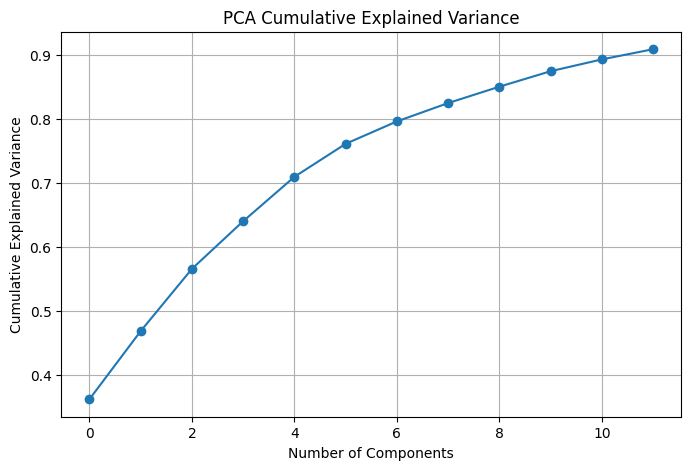

In [ ]:

pca = PCA(n_components=0.9)  # Retain 90% of the variance
node1_features_scaled_pca = pca.fit_transform(node1_features_scaled)

print("Original number of features:", node1_features.shape[1])
print("Reduced number of features:", node1_features_scaled_pca.shape[1])


# Variance explained by each principal component
print("Variance explained by each component:", pca.explained_variance_ratio_)

# Cumulative variance explained
cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("Cumulative variance explained:", cumulative_variance)

# Plotting the cumulative variance explained
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()


# Data Exploration

In [ ]:
node1_data.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,type
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,1.996939,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,1.992323,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [ ]:
node1_data.groupby('type')['type'].count()

type
0      49548
1     102195
2     107685
3     122573
4     237665
5      81982
6      59718
7      29068
8      29849
9      92141
10    105874
Name: type, dtype: int64

In [ ]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(node1_data.head())

First few rows of the dataset:
   MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0          1.000000       60.000000            0.000000          1.000000   
1          1.000000      354.000000            0.000000          1.000000   
2          1.857879      360.458980           35.789338          1.912127   
3          1.000000      337.000000            0.000000          1.000000   
4          1.680223      172.140917        18487.448750          1.793580   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       60.000000            0.000000          1.000000       60.000000   
1      354.000000            0.000000          1.000000      354.000000   
2      360.275733           35.923972          1.969807      360.091968   
3      337.000000            0.000000          1.000000      337.000000   
4      182.560279        18928.175300          1.925828      193.165753   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpHp_L0

In [ ]:

# Display summary statistics
print("\nSummary statistics of the dataset:")
print(node1_data.describe())


Summary statistics of the dataset:
       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      1.018298e+06    1.018298e+06        1.018298e+06      1.018298e+06   
mean       9.479704e+01    1.927187e+02        1.970133e+04      1.502972e+02   
std        6.380090e+01    1.631548e+02        2.517558e+04      1.010881e+02   
min        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
25%        1.124271e+01    6.000000e+01        3.755417e-09      2.661462e+01   
50%        1.108011e+02    7.407356e+01        3.869695e+01      1.870080e+02   
75%        1.471055e+02    3.308499e+02        4.867314e+04      2.311400e+02   
max        3.416813e+02    8.861669e+02        1.738886e+05      4.704900e+02   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    1.018298e+06        1.018298e+06      1.018298e+06    1.018298e+06   
mean     1.934838e+02        2.200175e+04      4.328257e+02    1.947330e+02 

In [ ]:
# Check for missing values
print("\nMissing values in the dataset:")
print(node1_data.isnull().sum())


Missing values in the dataset:
MI_dir_L5_weight         0
MI_dir_L5_mean           0
MI_dir_L5_variance       0
MI_dir_L3_weight         0
MI_dir_L3_mean           0
                        ..
HpHp_L0.01_magnitude     0
HpHp_L0.01_radius        0
HpHp_L0.01_covariance    0
HpHp_L0.01_pcc           0
type                     0
Length: 116, dtype: int64


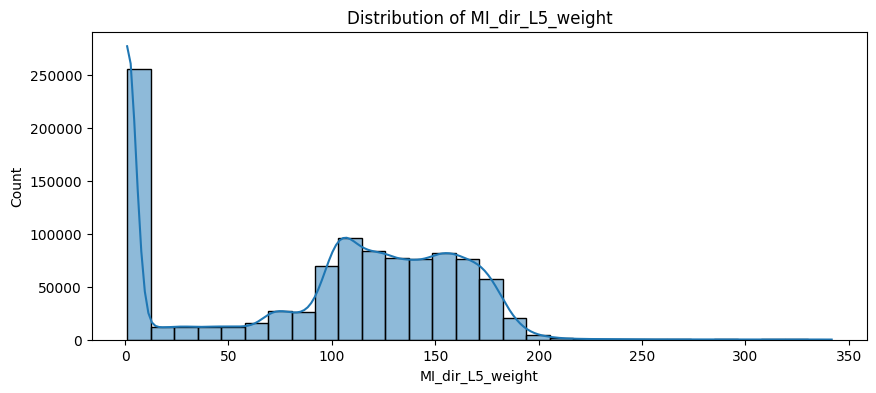

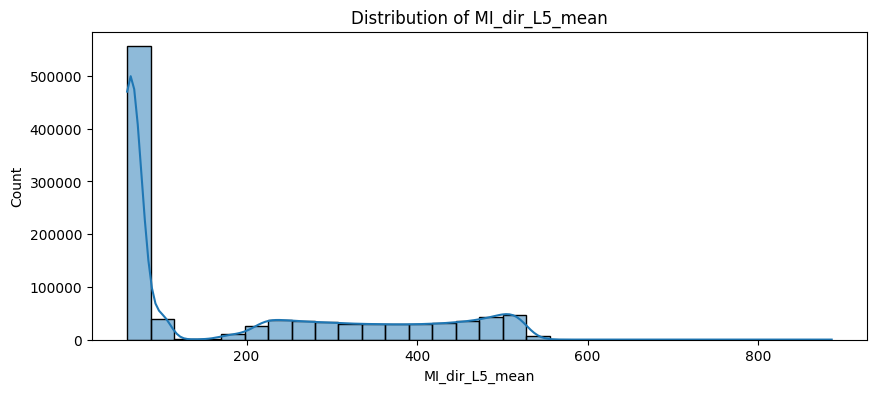

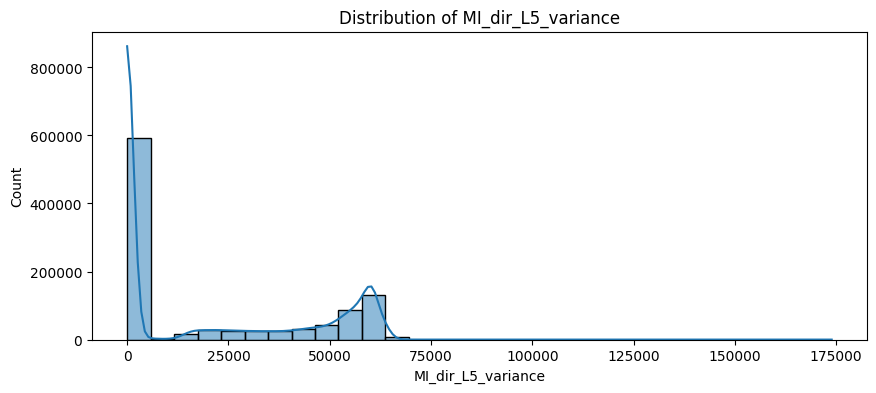

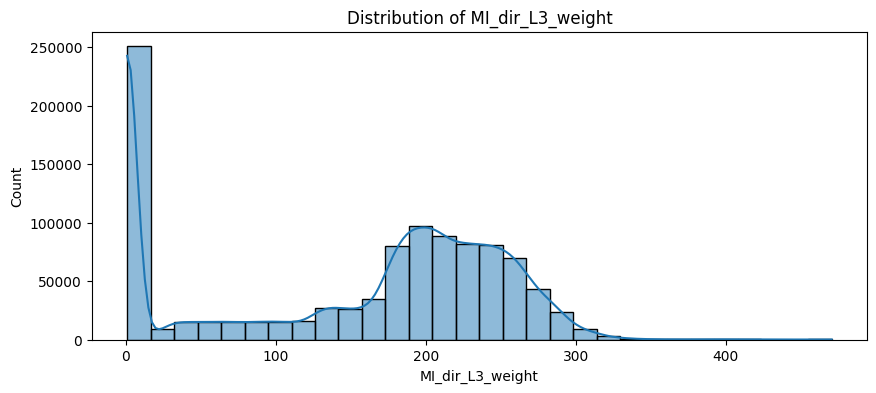

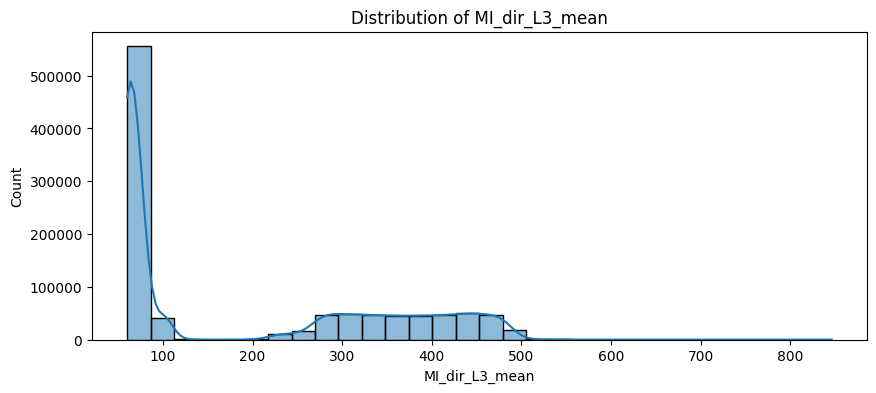

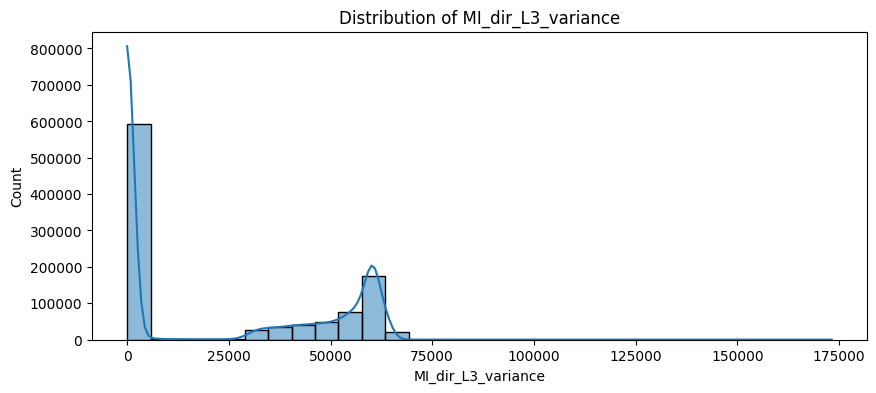

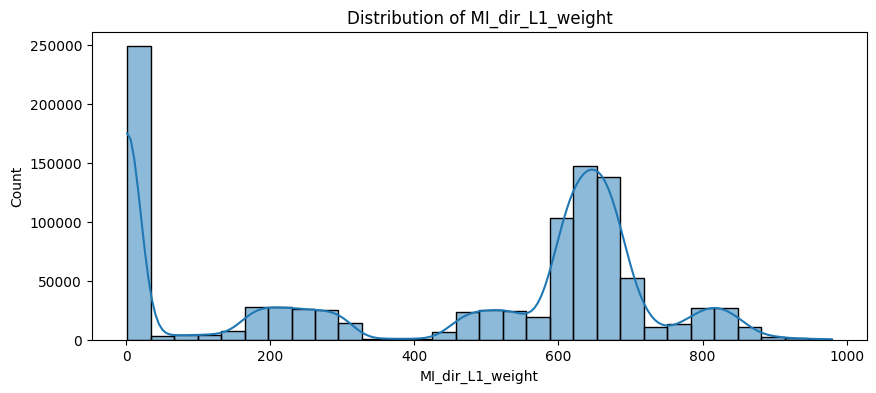

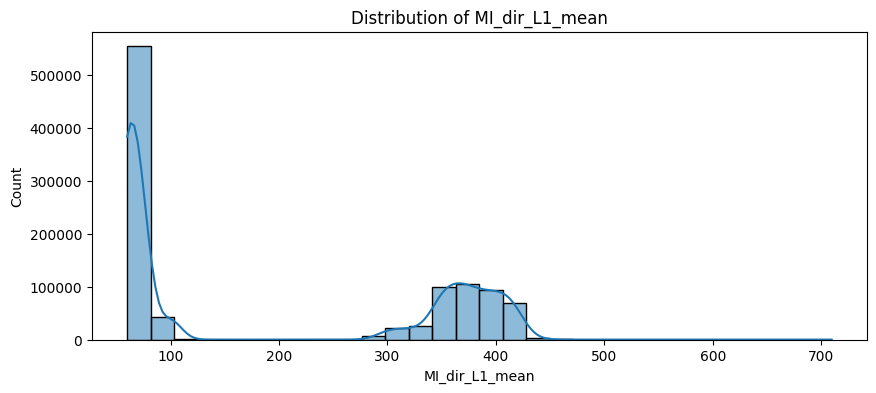

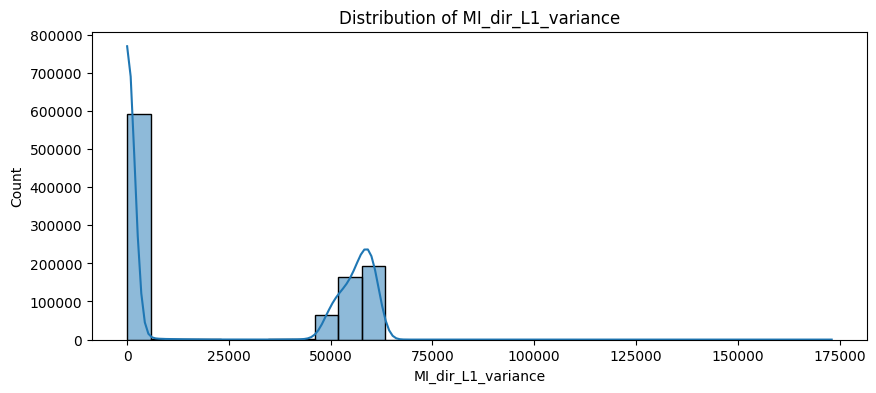

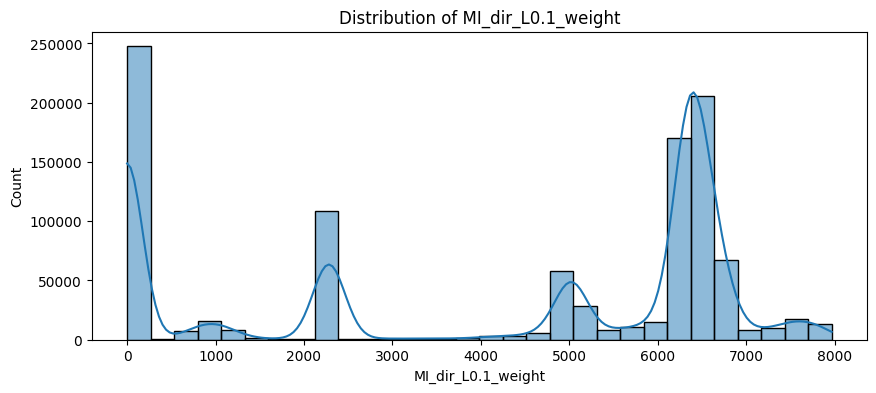

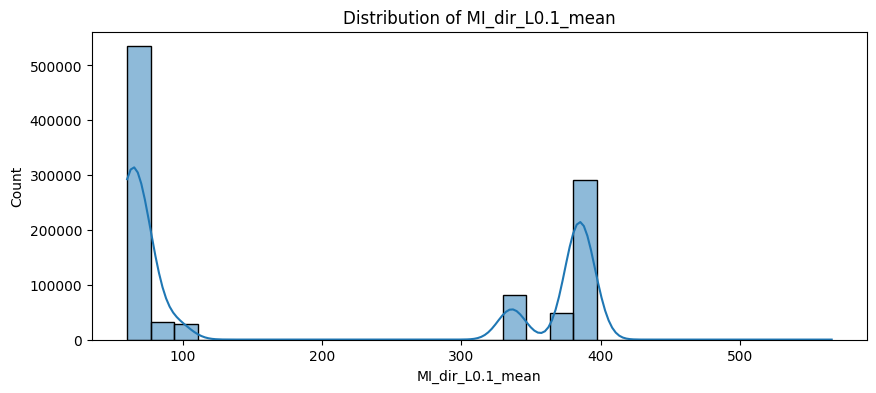

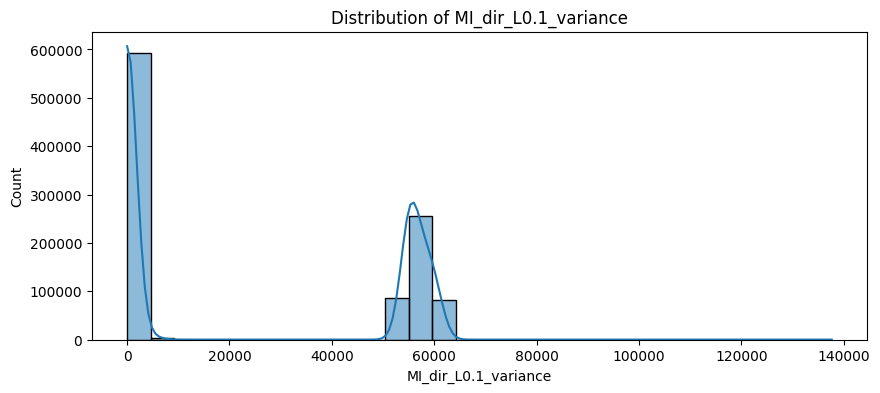

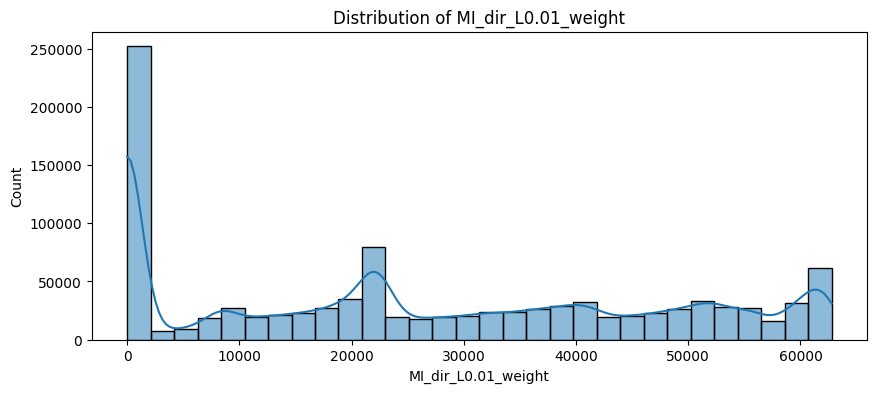

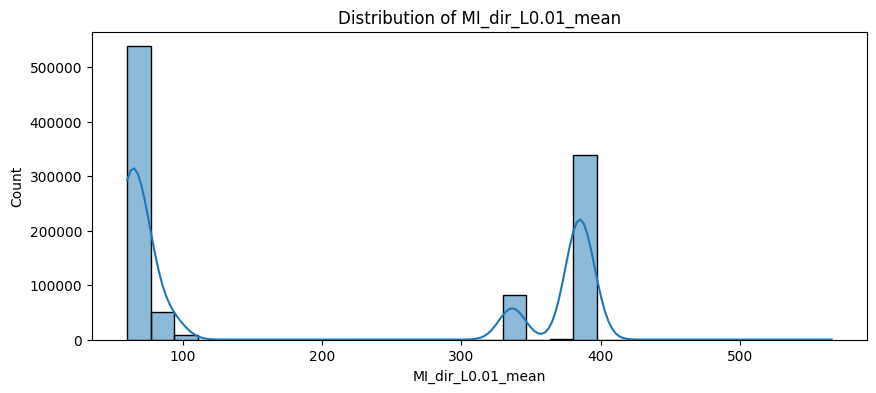

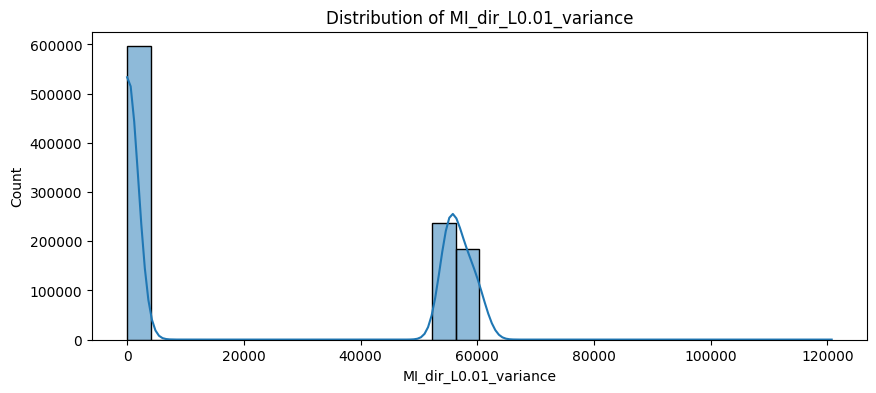

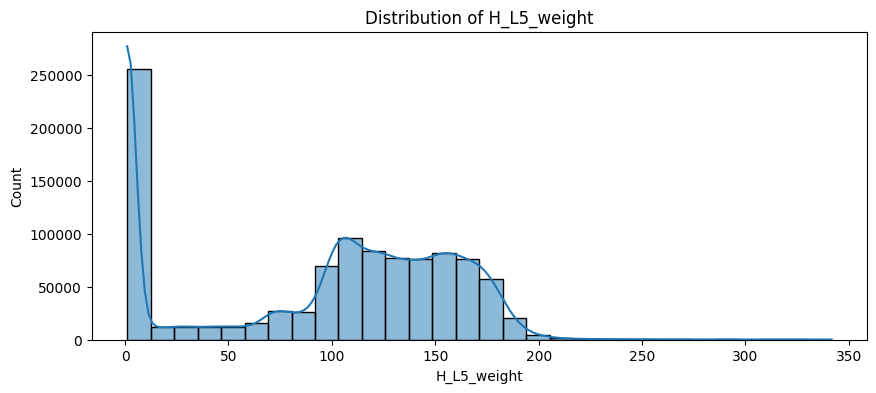

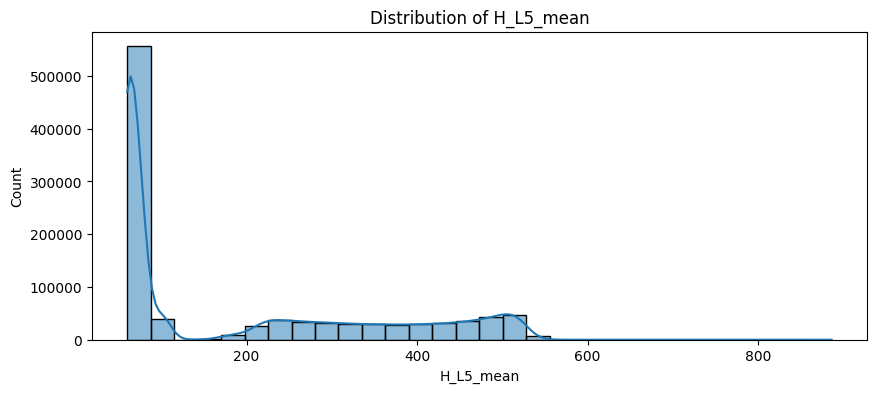

KeyboardInterrupt: 

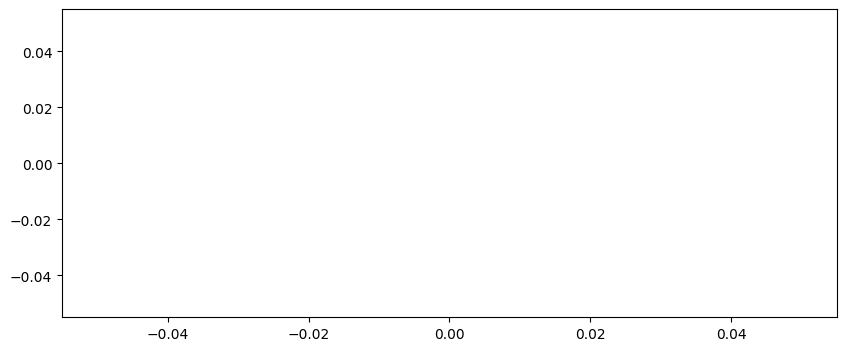

In [ ]:
# Visualize distributions of numerical features
#numerical_columns = node1_data.select_dtypes(include=['float64', 'int64']).columns
#for col in numerical_columns:
    #plt.figure(figsize=(10, 4))
    #sns.histplot(node1_data[col], kde=True, bins=30)
    #plt.title(f'Distribution of {col}')
    #plt.show()

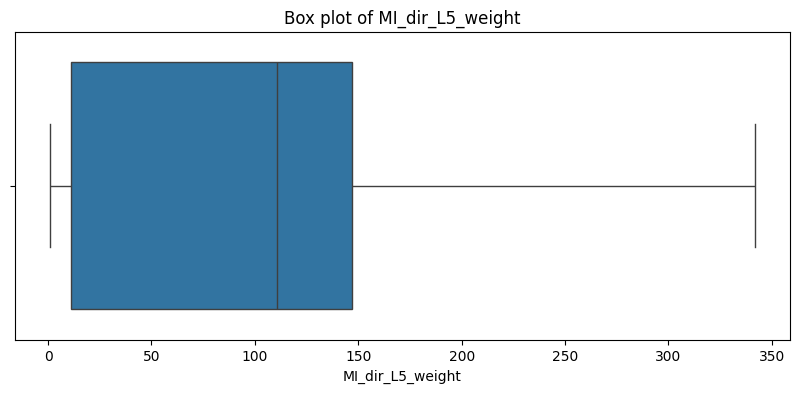

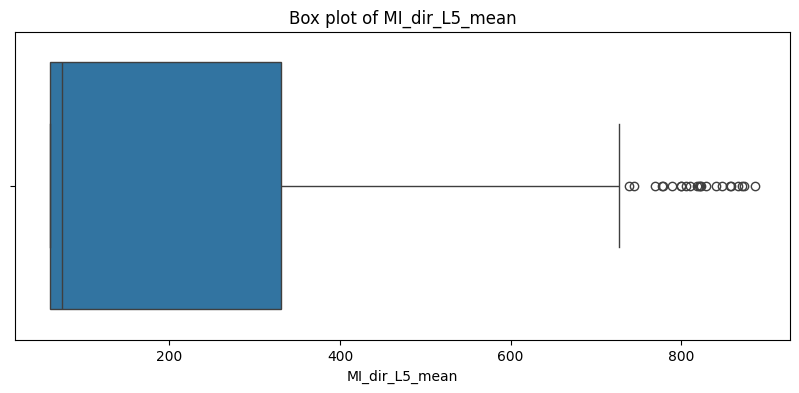

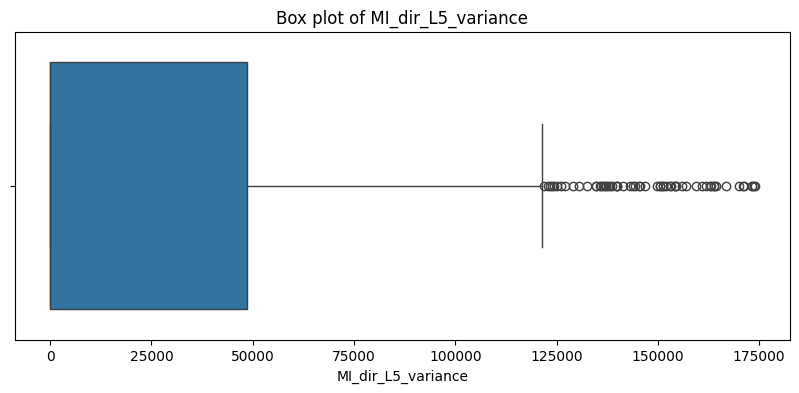

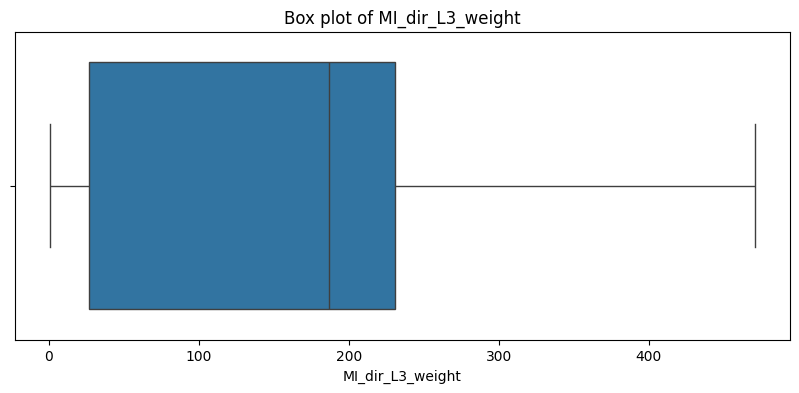

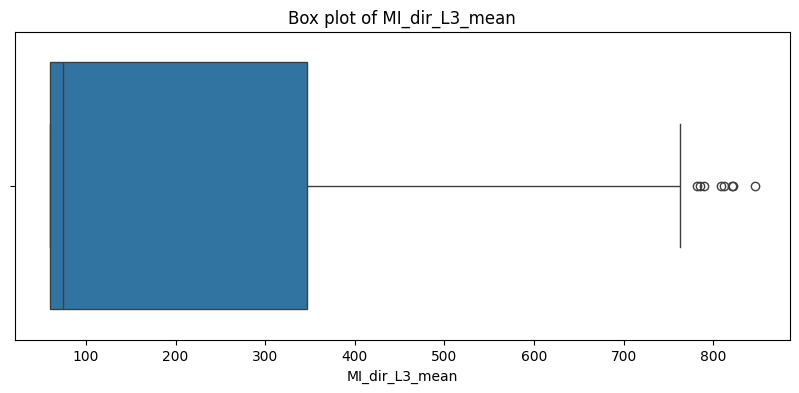

KeyboardInterrupt: 

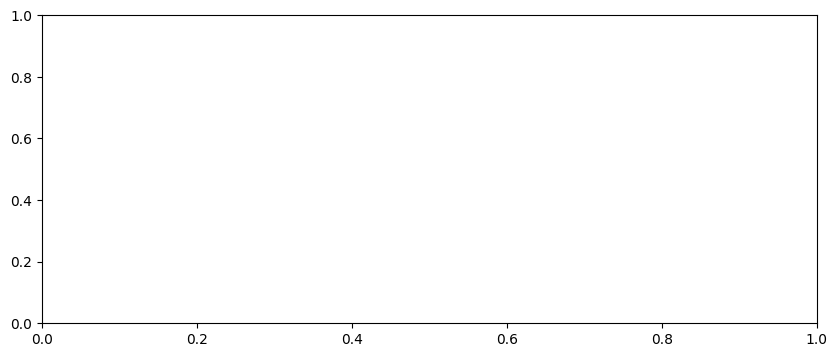

In [ ]:
# Box plot for numerical features to identify outliers
#for col in numerical_columns:
    #plt.figure(figsize=(10, 4))
    #sns.boxplot(x=node1_data[col])
    #plt.title(f'Box plot of {col}')
    #plt.show()

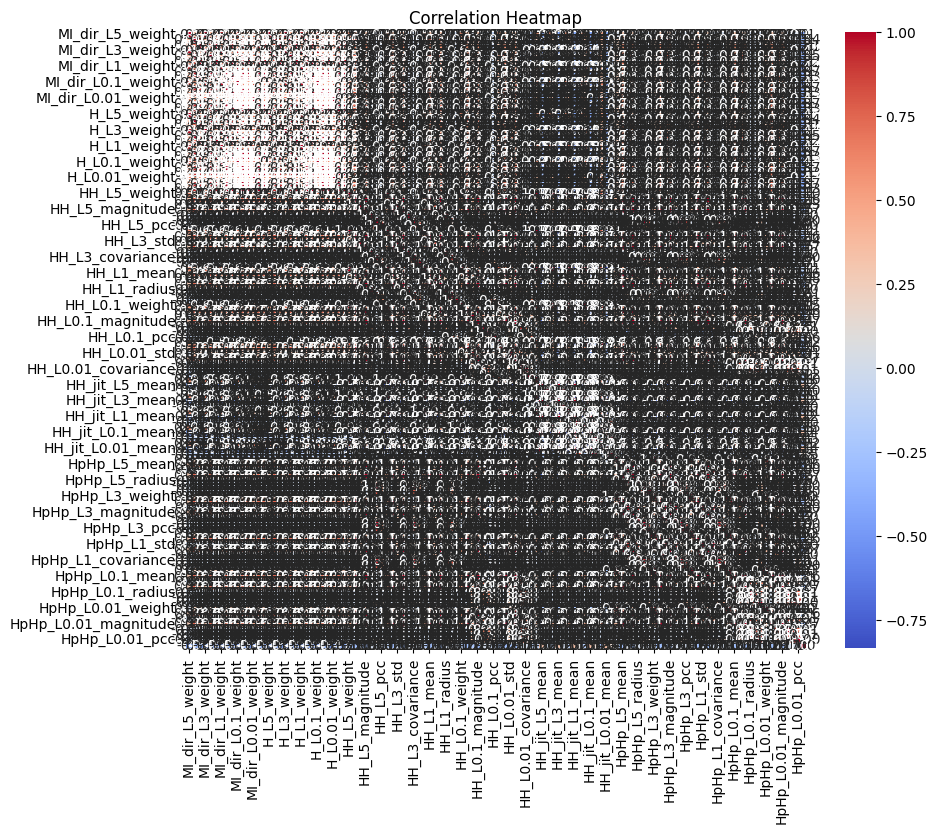

In [ ]:
# Correlation heatmap for numerical features
#plt.figure(figsize=(10, 8))
#sns.heatmap(node1_data[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Correlation Heatmap')
#plt.show()

In [ ]:

# Pairplot for relationships between features (optional, might be heavy for large datasets)
#sns.pairplot(node1_data)
#plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7cd8edc39000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7cd8edc38280> (for post_execute):


KeyboardInterrupt: 

## Node # 2

In [ ]:
# Load data for Node # 2
benign =pd.read_csv(path_root+ '2.benign.csv')
mirai_ack =pd.read_csv(path_root+ '2.mirai.ack.csv')
mirai_scan = pd.read_csv(path_root + '2.mirai.scan.csv')
mirai_syn = pd.read_csv(path_root + '2.mirai.syn.csv')
mirai_udp = pd.read_csv(path_root + '2.mirai.udp.csv')
mirai_udp_plain = pd.read_csv(path_root + '2.mirai.udpplain.csv')
gafgyt_combo = pd.read_csv(path_root + '2.gafgyt.combo.csv')
gafgyt_junk = pd.read_csv(path_root + '2.gafgyt.junk.csv')
gafgyt_scan = pd.read_csv(path_root + '2.gafgyt.scan.csv')
gafgyt_tcp = pd.read_csv(path_root + '2.gafgyt.tcp.csv')
gafgyt_udp = pd.read_csv(path_root + '2.gafgyt.udp.csv')

# Create type column for Node # 2
benign['type']= 0 #'benign'
mirai_ack['type']=1 #'mirai_ack'
mirai_scan['type']=2 #'mirai_scan'
mirai_syn['type'] = 3 #'mirai_syn'
mirai_udp['type'] = 4 #'mirai_udp'
mirai_udp_plain['type'] = 5 #'mirai_udp_plain'

gafgyt_combo['type'] = 6 #'gafgyt_combo'
gafgyt_junk['type'] = 7 #'gafgyt_junk'
gafgyt_scan['type'] = 8 #'gafgyt_scan'
gafgyt_tcp['type'] = 9 #'gafgyt_tcp'
gafgyt_udp['type'] = 10 #'gafgyt_udp'

#construct the main dataset for node # 2
node2_data = pd.concat([benign,
                  mirai_ack, mirai_scan, mirai_syn, mirai_udp, mirai_udp_plain,
                 gafgyt_combo, gafgyt_junk, gafgyt_scan, gafgyt_tcp, gafgyt_udp],
                 axis=0, sort=False, ignore_index=True)

## Orginal Data

In [ ]:
from sklearn.model_selection import train_test_split


#node1_features_train, node1_features_test, node1_labels_train, node1_labels_test =
#train_test_split(node1_features, node1_labels, test_size=0.33, random_state=42, shuffle=True)

## Node # 1 ###
#==============
# Split the dataset into a training set and a temporary set (combining validation and test) with a first train_test_split
node1_features_train, node1_features_temp, node1_labels_train, node1_labels_temp = train_test_split(
    node1_features, node1_labels, test_size=0.2, random_state=42, shuffle=True) #node1_features

# Further split the temporary set into validation and test sets with a second train_test_split
node1_features_val, node1_features_test, node1_labels_val, node1_labels_test = train_test_split(
    node1_features_temp, node1_labels_temp, test_size=0.5, random_state=42, shuffle=True)

# At this point, you have:
# features_train, labels_train for training (60% of the dataset)
# features_val, labels_val for validation (20% of the dataset)
# features_test, labels_test for testing (20% of the dataset)

# If you want to check the size of each set
print("Node # 1")
print("Training set size:", node1_features_train.shape[0])
print("Validation set size:", node1_features_val.shape[0])
print("Testing set size:", node1_features_test.shape[0])



## Node # 2 ###
#==============
# Split the dataset into a training set and a temporary set (combining validation and test) with a first train_test_split
node2_features_train, node2_features_temp, node2_labels_train, node2_labels_temp = train_test_split(
    node2_features, node2_labels, test_size=0.2, random_state=42, shuffle=True) #node1_features

# Further split the temporary set into validation and test sets with a second train_test_split
node2_features_val, node2_features_test, node2_labels_val, node2_labels_test = train_test_split(
    node2_features_temp, node2_labels_temp, test_size=0.5, random_state=42, shuffle=True)

# At this point, you have:
# features_train, labels_train for training (60% of the dataset)
# features_val, labels_val for validation (20% of the dataset)
# features_test, labels_test for testing (20% of the dataset)

# If you want to check the size of each set
print("Node # 2")
print("Training set size:", node2_features_train.shape[0])
print("Validation set size:", node2_features_val.shape[0])
print("Testing set size:", node2_features_test.shape[0])

Node # 1
Training set size: 814638
Validation set size: 101830
Testing set size: 101830
Node # 2
Training set size: 668700
Validation set size: 83588
Testing set size: 83588


## PCA Data

In [ ]:
from sklearn.model_selection import train_test_split


#node1_features_train, node1_features_test, node1_labels_train, node1_labels_test =
#train_test_split(node1_features, node1_labels, test_size=0.33, random_state=42, shuffle=True)


# Split the dataset into a training set and a temporary set (combining validation and test) with a first train_test_split
node1_features_train_PCA, node1_features_temp_PCA, node1_labels_train_PCA, node1_labels_temp_PCA = train_test_split(
    node1_features_scaled_pca, node1_labels, test_size=0.2, random_state=42, shuffle=True)

# Further split the temporary set into validation and test sets with a second train_test_split
node1_features_val_PCA, node1_features_test_PCA, node1_labels_val_PCA, node1_labels_test_PCA = train_test_split(
    node1_features_temp_PCA, node1_labels_temp_PCA, test_size=0.5, random_state=42, shuffle=True)

# At this point, you have:
# features_train, labels_train for training (60% of the dataset)
# features_val, labels_val for validation (20% of the dataset)
# features_test, labels_test for testing (20% of the dataset)

# If you want to check the size of each set
print("Training set size:", node1_features_train_PCA.shape[0])
print("Validation set size:", node1_features_val_PCA.shape[0])
print("Testing set size:", node1_features_test_PCA.shape[0])

Training set size: 814638
Validation set size: 101830
Testing set size: 101830


# Temp Code

In [ ]:
# Load data for Node # 1
#benign =pd.read_csv(path_root+ '1.benign.csv')
#mirai_ack =pd.read_csv(path_root+ '1.mirai.ack.csv')
#mirai_scan = pd.read_csv(path_root + '1.mirai.scan.csv')
#mirai_syn = pd.read_csv(path_root + '1.mirai.syn.csv')
#mirai_udp = pd.read_csv(path_root + '1.mirai.udp.csv')
#mirai_udp_plain = pd.read_csv(path_root + '1.mirai.udpplain.csv')
#gafgyt_combo = pd.read_csv(path_root + '1.gafgyt.combo.csv')
#gafgyt_junk = pd.read_csv(path_root + '1.gafgyt.junk.csv')
#gafgyt_scan = pd.read_csv(path_root + '1.gafgyt.scan.csv')
#gafgyt_tcp = pd.read_csv(path_root + '1.gafgyt.tcp.csv')
#gafgyt_udp = pd.read_csv(path_root + '1.gafgyt.udp.csv')

# Create type column for Node # 1
#benign['type']= 0 #'benign'
#mirai_ack['type']=1 #'mirai_ack'
#mirai_scan['type']=2 #'mirai_scan'
#mirai_syn['type'] = 3 #'mirai_syn'
#mirai_udp['type'] = 4 #'mirai_udp'
#mirai_udp_plain['type'] = 5 #'mirai_udp_plain'

#gafgyt_combo['type'] = 6 #'gafgyt_combo'
#gafgyt_junk['type'] = 7 #'gafgyt_junk'
#gafgyt_scan['type'] = 8 #'gafgyt_scan'
#gafgyt_tcp['type'] = 9 #'gafgyt_tcp'
#gafgyt_udp['type'] = 10 #'gafgyt_udp'

#construct the main dataset for node # 1
#node1_data = pd.concat([benign,
#                  mirai_ack, mirai_scan, mirai_syn, mirai_udp, mirai_udp_plain,
#                 gafgyt_combo, gafgyt_junk, gafgyt_scan, gafgyt_tcp, gafgyt_udp],
#                 axis=0, sort=False, ignore_index=True)


nodes_data = load_all_nodes_data(number_of_nodes)
node1_data = get_node_data(nodes_data,1)
node1_data.groupby('type')['type'].count()

node2_data = get_node_data(nodes_data,2)
node2_data.groupby('type')['type'].count()

## Node # 2 Data Training ###

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

## Main Data ####
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Record the start time
start_time = time.time()

# Train the classifier on the training set
clf.fit(node2_features_train, node2_labels_train)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Model training completed in {training_time:.4f} seconds.")


## Node # 2 ##
# Predict on the testing set
y_pred = clf.predict(node2_features_val)

# Evaluate the classifier
accuracy = accuracy_score(node2_labels_val, y_pred)
print(f"Accuracy - Normal Data - Node 2: {accuracy}")

## Node # 1 ##
# Use node 1 data to test model accuracy trained on node 2 data
# This will show if there is a room for enhancement by federated ML

# Predict on the testing set
y_pred = clf.predict(node1_features_val)

# Evaluate the classifier
accuracy = accuracy_score(node1_labels_val, y_pred)
print(f"Accuracy - Normal Data - Node 1: {accuracy}")



from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

## Main Data ####
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Record the start time
start_time = time.time()

# Train the classifier on the training set
clf.fit(node1_features_train, node1_labels_train)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Model training completed in {training_time:.4f} seconds.")


## Node # 1 ##
# Predict on the testing set
y_pred = clf.predict(node1_features_val)

# Evaluate the classifier
accuracy = accuracy_score(node1_labels_val, y_pred)
print(f"Accuracy - Normal Data- Node 1: {accuracy}")

## Node # 2 ##
# Use node 2 data to test model accuracy trained on node 1 data
# This will show if there is a room for enhancement by federated ML

# Predict on the testing set
y_pred = clf.predict(node2_features_val)

# Evaluate the classifier
accuracy = accuracy_score(node2_labels_val, y_pred)
print(f"Accuracy - Normal Data - Node 2: {accuracy}")


## PCA Data ###

# Initialize the Decision Tree classifier
clf_PCA = DecisionTreeClassifier(random_state=42)

# Record the start time
start_time = time.time()

# Train the classifier on the training set
clf_PCA.fit(node1_features_train_PCA, node1_labels_train_PCA)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Model training completed in {training_time:.4f} seconds.")

# Predict on the testing set
y_pred_PCA = clf_PCA.predict(node1_features_val_PCA)

# Evaluate the classifier
accuracy_PCA = accuracy_score(node1_labels_val_PCA, y_pred_PCA)
print(f"Accuracy - PCA Data: {accuracy_PCA}")